### Objective:

- The aim of the project is to identify if a person is infected by SARS-Cov-2(COVID-19) by analysing their CT Scan.
- These data have been collected from real patients in hospitals from Sao Paulo, Brazil.
- The dataset used in this model is put together by *Angelov, Plamen, and Eduardo Almeida Soares.* 
<br>("EXPLAINABLE-BY-DESIGN APPROACH FOR COVID-19 CLASSIFICATION VIA CT-SCAN." medRxiv (2020).)
- OpenCV and Keras libraries are used to solve this problem.

**Importing necessary libraries**

In [1]:
import cv2
import os

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K  
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score,f1_score


import matplotlib.pyplot as plt
%matplotlib inline

# import random
# random.seed(10)

Using TensorFlow backend.


**Defining a function to load the dataset**

Following preprocessing methods are done on the dataset
- Images are rotated at 90 degree
- Converted from default BGR format to RGB format for matplotlib
- Nearest neighbour interpolation method is used
- Images are resized to a fixed input size of (100,100)

In [2]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            rows,cols = img.shape[:2] 
            M = cv2.getRotationMatrix2D((cols/2,rows/2),90,1) 
            img_rotated = cv2.warpAffine(img,M,(cols,rows)) 
            rgb_img= cv2.cvtColor(img_rotated,cv2.COLOR_BGR2RGB)
            img_scaled = cv2.resize(rgb_img, (100, 100), interpolation =cv2.INTER_NEAREST)
            images.append(img_scaled)
    return images

- Loading the dataset

In [3]:
covid=load_images_from_folder("C:/Users/teena/Desktop/Jupyter/ML/Covid19/COVID_CTSCAN/dataset/COVID")
non_covid=load_images_from_folder("C:/Users/teena/Desktop/Jupyter/ML/Covid19/COVID_CTSCAN/dataset/non-COVID")

**Data Exploration**

- Checking number of samples in each class (covid and non_covid)

In [4]:

print("number of samples under class covid is:", len(covid))
print("number of samples under class non-covid is:", len(non_covid))

number of samples under class covid is: 1252
number of samples under class non-covid is: 1229


- Checking the size of a sample image from each class

In [5]:
print("Size of an image from covid sample is:", covid[0].shape)
print("Size of an image from non_covid sample is:", non_covid[0].shape)

Size of an image from covid sample is: (100, 100, 3)
Size of an image from non_covid sample is: (100, 100, 3)


- Displaying an image from class "covid"

Displaying a Covid Image


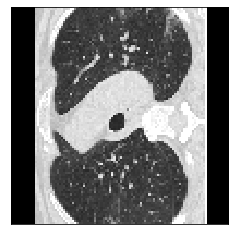

In [6]:
print("Displaying a Covid Image")
plt.imshow(covid[0], cmap = 'gray')
plt.xticks([]), plt.yticks([]) 
plt.show()

- Displaying an image from class "non_covid"

Displaying a Non_Covid Image


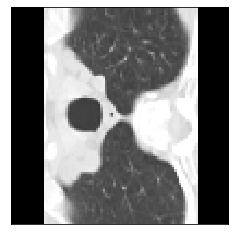

In [7]:
print("Displaying a Non_Covid Image")
plt.imshow(non_covid[0], cmap = 'gray')
plt.xticks([]), plt.yticks([])  
plt.show()

**Assigning labels to images from each class**

In [8]:

covid_df = pd.DataFrame({'image':covid})
covid_df['Is_Covid'] = 1

non_covid_df = pd.DataFrame({'image':non_covid})
non_covid_df['Is_Covid'] = 0

data = pd.concat([covid_df,non_covid_df], ignore_index=True)
data=data.sample(frac=1)
data

,image,Is_Covid
941,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",1
1134,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",1
1078,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",1
1347,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0
2168,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0
...,...,...
1505,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0
1778,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0
1419,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0
942,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",1


**Separating the target variable and the feature variable**

In [9]:
target = data['Is_Covid']


features = data['image']

- Transforming the feature variable to be passed to the model

In [10]:
feat_lis = features.values

X = []
for i in range(0,len(feat_lis)):
    X.append(feat_lis[i].tolist())
X_array=np.array(X)

In [11]:
print("Shape of input data is:", X_array.shape)

Shape of input data is: (2481, 100, 100, 3)


**Splitting the data into train and test set**

In [12]:
x_train, x_test, y_train, y_test = train_test_split(X_array, target, test_size=0.3, random_state=42)

In [13]:
print('Number of non-covid samples in test data: ', len(y_test[y_test == 0]))
print('Number of covid samples in test data: ', len(y_test[y_test == 1]))

Number of non-covid samples in test data:  361
Number of covid samples in test data:  384


In [14]:
x_train[0].shape

(100, 100, 3)

**Defining Model and Metrics to evaluate**
- Sequential model is used to solve the classification problem
- EarlyStopping is employed monitoring validation accuracy
- ModelCheckpoint is used to save network weights when there is an improvement
- Activation functions used are *Rectified Linear Unit(ReLU)* and *Sigmoid* on the output layer
- The model is compiled specifying *binary_crossentropy* as loss function and *adam* as the optimizer.
- **Accuracy and F1-Score** are used to evaluate the model

In [15]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=x_train[0].shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

early_stopping= EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10)
model_checkpoint = ModelCheckpoint('v3_one_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

history = model.fit(x_train, y_train, validation_split=0.2, epochs=50, verbose=1, callbacks=[early_stopping,model_checkpoint])

Train on 1388 samples, validate on 348 samples
Epoch 1/50
1388/1388 [==============================] - 7s 5ms/step - loss: 3.4187 - accuracy: 0.5425 - val_loss: 0.6934 - val_accuracy: 0.5977

Epoch 00001: val_accuracy improved from -inf to 0.59770, saving model to v3_one_model.h5
Epoch 2/50
1388/1388 [==============================] - 6s 4ms/step - loss: 0.6406 - accuracy: 0.6390 - val_loss: 0.5732 - val_accuracy: 0.6839

Epoch 00002: val_accuracy improved from 0.59770 to 0.68391, saving model to v3_one_model.h5
Epoch 3/50
1388/1388 [==============================] - 6s 4ms/step - loss: 0.5837 - accuracy: 0.6852 - val_loss: 0.5114 - val_accuracy: 0.7414

Epoch 00003: val_accuracy improved from 0.68391 to 0.74138, saving model to v3_one_model.h5
Epoch 4/50
1388/1388 [==============================] - 6s 4ms/step - loss: 0.5469 - accuracy: 0.7147 - val_loss: 0.5096 - val_accuracy: 0.7644

Epoch 00004: val_accuracy improved from 0.74138 to 0.76437, saving model to v3_one_model.h5
Epoch 5/

1388/1388 [==============================] - 6s 4ms/step - loss: 0.1299 - accuracy: 0.9445 - val_loss: 0.3403 - val_accuracy: 0.8736

Epoch 00039: val_accuracy did not improve from 0.89368
Epoch 40/50
1388/1388 [==============================] - 6s 4ms/step - loss: 0.1063 - accuracy: 0.9575 - val_loss: 0.3579 - val_accuracy: 0.8678

Epoch 00040: val_accuracy did not improve from 0.89368
Epoch 41/50
1388/1388 [==============================] - 6s 4ms/step - loss: 0.0990 - accuracy: 0.9589 - val_loss: 0.3277 - val_accuracy: 0.8707

Epoch 00041: val_accuracy did not improve from 0.89368
Epoch 42/50
1388/1388 [==============================] - 6s 4ms/step - loss: 0.1034 - accuracy: 0.9597 - val_loss: 0.2719 - val_accuracy: 0.8966

Epoch 00042: val_accuracy improved from 0.89368 to 0.89655, saving model to v3_one_model.h5
Epoch 43/50
1388/1388 [==============================] - 6s 4ms/step - loss: 0.0896 - accuracy: 0.9568 - val_loss: 0.3231 - val_accuracy: 0.8966

Epoch 00043: val_accuracy

##### Evaluating the model

In [16]:
best_model=load_model('v3_one_model.h5')

loss, train_acc= best_model.evaluate(x_train, y_train, verbose=2)
print("Train Accuracy on best model is:", train_acc)

loss, test_acc = best_model.evaluate(x_test, y_test, verbose=2)
print("Test Accuracy on best model is:", test_acc)

y_pred = best_model.predict(x_test)
y_pred_ = np.where(y_pred<0.5,0,1)

confusion_matrix_= confusion_matrix(y_test, y_pred_)
print(confusion_matrix_)


accuracy_= accuracy_score(y_test, y_pred_)
print("Accuracy of the model prediction is:", accuracy_)

f1_score_=f1_score(y_test, y_pred_, average="binary")
print("F1-Score of the model is:",f1_score_ )

Train Accuracy on best model is: 0.9735022783279419
Test Accuracy on best model is: 0.8644295334815979
[[314  47]
 [ 54 330]]
Accuracy of the model prediction is: 0.8644295302013423
F1-Score of the model is: 0.8672798948751642


#### Plotting Training Loss and Validation Loss
- Learning curve is plotted to understand how well the model is learning over time
- It can help diagonse if a model is underfit, overfit or well-fit
- It can also be used to understand if the train and validation datasets are not relatively represenative of the problem domain

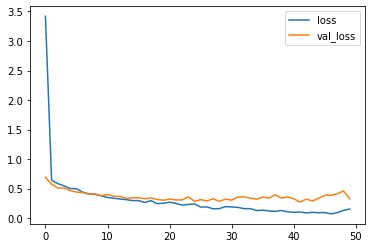

In [17]:
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

**Result of the model**

- Though the model has good accuracy and F1-Score around 86%, the model is overfit as we see from the plot above.
- The overfitting problem shall be addressed in the next model.
- The problem with overfitting, is that the more specialized the model becomes to training data, the less well it is able to generalize to new data, resulting in an increase in generalization error. 

In [18]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=x_train[0].shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

early_stopping= EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5)
model_checkpoint = ModelCheckpoint('v3_two_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

history = model.fit(x_train, y_train, validation_split=0.2, epochs=50, verbose=1, callbacks=[early_stopping,model_checkpoint])

Train on 1388 samples, validate on 348 samples
Epoch 1/50
1388/1388 [==============================] - 6s 5ms/step - loss: 7.0092 - accuracy: 0.5173 - val_loss: 0.6778 - val_accuracy: 0.5862

Epoch 00001: val_accuracy improved from -inf to 0.58621, saving model to v3_two_model.h5
Epoch 2/50
1388/1388 [==============================] - 6s 4ms/step - loss: 0.6862 - accuracy: 0.5432 - val_loss: 0.6726 - val_accuracy: 0.5776

Epoch 00002: val_accuracy did not improve from 0.58621
Epoch 3/50
1388/1388 [==============================] - 6s 4ms/step - loss: 0.6742 - accuracy: 0.5785 - val_loss: 0.6600 - val_accuracy: 0.6236

Epoch 00003: val_accuracy improved from 0.58621 to 0.62356, saving model to v3_two_model.h5
Epoch 4/50
1388/1388 [==============================] - 6s 4ms/step - loss: 0.6537 - accuracy: 0.6160 - val_loss: 0.6567 - val_accuracy: 0.5833

Epoch 00004: val_accuracy did not improve from 0.62356
Epoch 5/50
1388/1388 [==============================] - 6s 4ms/step - loss: 0.6501

In [19]:
best_model=load_model('v3_two_model.h5')

loss, train_acc= best_model.evaluate(x_train, y_train, verbose=2)
print("Train Accuracy on best model is:", train_acc)

loss, test_acc = best_model.evaluate(x_test, y_test, verbose=2)
print("Test Accuracy on best model is:", test_acc)

y_pred = best_model.predict(x_test)
y_pred_ = np.where(y_pred<0.5,0,1)

confusion_matrix_= confusion_matrix(y_test, y_pred_)
print(confusion_matrix_)


accuracy_= accuracy_score(y_test, y_pred_)
print("Accuracy of the model prediction is:", accuracy_)

f1_score_=f1_score(y_test, y_pred_, average="binary")
print("F1-Score of the model is:",f1_score_ )

Train Accuracy on best model is: 0.9170507192611694
Test Accuracy on best model is: 0.8389261960983276
[[305  56]
 [ 64 320]]
Accuracy of the model prediction is: 0.8389261744966443
F1-Score of the model is: 0.8421052631578947


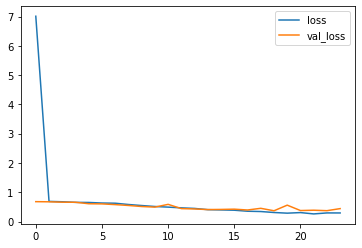

In [20]:
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

**Result of the model**

- Though the model has lesser accuracy and F1-Score,  than the previous one, which is around 84%, the model doesnt suffer from overfitting.
- The model is well-fit as seen from the learning curve.

**References:**
- https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/   
- https://scikit-learn.org/stable/modules/model_evaluation.html                                                               
- https://keras.io/api/models/sequential/
- https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint  
- https://www.analyticsvidhya.com/blog/2019/03/opencv-functions-computer-vision-python/